# My Neural Network


## #Goal:
- Create a multi-layer perceptron from scratch

### - How to achieve goal?
1. We need to create a framework (a micrograd replica) to track all the operations that take place and enable us to backpropagate through the entire process.
2. Then we need to create a single neuron.
3. After that we create a layer consisting of multiple neurons
4. Finally, we connect multiple layers to create a multi-layer perceptron.

### - Steps for a Single Neuron:

1. **Input Features**: Input features (Xs) are fed into the neuron.
2. **Weights**: Each feature is multiplied by a weight (Ws). Since we can't directly modify the input (X), we use the weight (W) to adjust it.
3. **Summation**: The results of all Xs multiplied by their respective Ws are summed.
4. **Activation Function**: We pass the sum through an activation function (e.g., `tanh`), which limits the output between -1 and 1.
5. **Evaluation Function**: Finally, we use an evaluation function to assess the neuron's output.

- Backpropagation can then be used to asses the value of each weight and the bias to the result of the evaluation function. Modifcations can then be done to minimize the loss given by the evaluation function.

### - Steps for creating a layer of neurons:

1. creating a list of neurons, each taking all the inputs provided to the layer.
2. returning a list of results produced by each neuron.

### - Steps for a Multi-Layer Perceptron:

1. create a list of layers, with sizes that we wish for.
2. connect each layer to the layer before it and make the output of each layer the input of the next.
3. return the result produced by the MLP.

## #Important concepts to note:

### - What is Backpropagation?

- **Backpropagation** is the process of finding the effect of each variable in a series of operations by calculating the derivative of that variable with respect to the final expression.

### - What is the derevative of a function?

- The derivative of a function at a given value represents the gradient of the tangent line touching the function at that point. By knowing the gradient, we can then know the direction where the function is moving, either up or down. We do that by adding a very small value to the variable we are trying to see it's value to the function. The value must approach zero (limits).

- for example, let's say we are trying to find the derivative of h(x) with respect to x, aka find the value of change provided by variable x to the function. then we add a very small number that approaches 0. for demonstration purposes it will be 0.0001. Then we will subtract the value from x, so h(x-0.001). Now to see the effect we will subtract the original function from the equation to see the amount of difference. so h(x - 0.001) - h(x). the value will be so small so we will normalize it and divide it by the number that is approaching 0 (0.001 in our case). so (h(x - 0.001) - h(x)) / 0.001.

now the result will show us by numbers the rate of change of the function given the modification of x.

## A Micrograd Replica Framework

### Value class

In [12]:
import math


class Value:
    def __init__(self, data, _childern=(), _op='', label='', grad = 0.0):
        self.data = data
        self.grad = grad
        self._backward = lambda: None
        self._prev = set(_childern)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data * other.data,  (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)
        build_topo(self)
            
        self.grad = 1

        topo.reverse()
        for child in topo:
            child._backward()
        
    

### Function to visualize the operations going on:

In [13]:
from graphviz import Digraph # type: ignore

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Testing the framework

#### Creating a test neuron replica for testing purposes

In [ ]:
x1 = Value(0.6, label='x1')
w1 = Value(0.3, label='w1')
x2 = Value(1.0, label='x2')
w2 = Value(0, label='w2')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1 + x2w2'

b = Value(2.1, label='b')

total = x1w1x2w2 + b
total.label = 'sum'

act = total.tanh()
act.label = 'act'

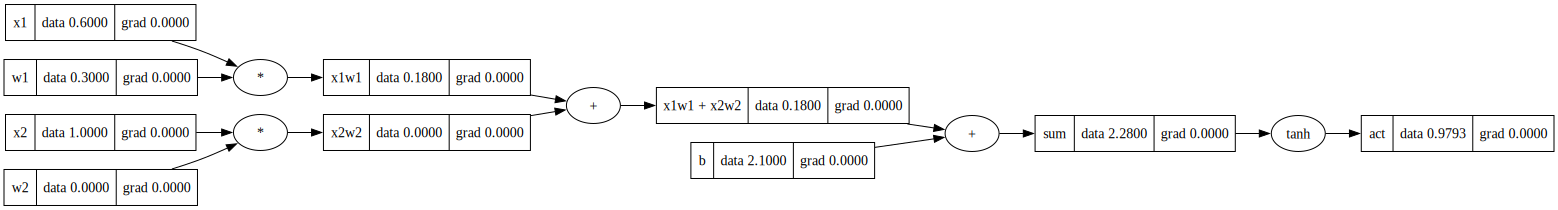

In [ ]:
draw_dot(act)

In [14]:
act.backward()

NameError: name 'act' is not defined

### Achieving same result with pytorch

In [194]:
import torch

x1 = torch.Tensor([0.6]).double()       ; x1.requires_grad = True
w1 = torch.Tensor([0.3]).double()       ; w1.requires_grad = True
x2 = torch.Tensor([1.0]).double()       ; x2.requires_grad = True
w2 = torch.Tensor([0.0]). double()      ; w2.requires_grad = True
b = torch.Tensor([2.1]).double()

total = (x1*w1) + (x2*w2) + b
act = torch.tanh(total)

print(act.data.item())
act.backward()

print('----')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.9792925216153839
----
x1 0.012295847621047903
w1 0.024591695242095805
x2 0.0
w2 0.040986157108182784


## Creating a single Neuron

In [15]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def parameters(self):
        return [self.b] + self.w
        
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        
        

### Testing the neuron:

In [16]:
x = [Value(1.2), Value(3.4), Value(0.5)]
n = Neuron(3)
result = n(x)
print(result)

Value(data=0.9935935114421333)


## Creating a single layer of Neurons

In [17]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

### Testing the layer:

In [18]:
x = [Value(1.2), Value(3.4), Value(0.5)]
l = Layer(3, 4)
l(x)

[Value(data=-0.9952997109715841),
 Value(data=0.26941359386062397),
 Value(data=0.9172688652413843),
 Value(data=0.8749725291022923)]

## Creating a Multi-layer Perceptron

In [19]:
class MLP:
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Testing the MLP:

In [20]:
x = [Value(1.2), Value(3.4), Value(0.5)]

m = MLP(3, [4, 4, 1])

m(x)

Value(data=0.5264589483590738)

## Using the MLP

In [21]:
xs = [                          #testing dataset
    [5, 1.5, 7.3],
    [6, 1.4, 5.1],
    [1.2, 0.5, 0.1],
    [1.3, 2.5, 0.9]
]

targetOuts = [1, 1, -1, -1]     #target variables

In [22]:
for k in range(100):

    #Forward pass:
    predection = [m(x) for x in xs]
    totalLoss = sum((y_out - y_target) ** 2 for y_target, y_out in zip(targetOuts, predection))

    #Backward pass:
    for p in m.parameters():        #zeroing the grad in each iteration
        p.grad = 0
        
    totalLoss.backward()

    #Update rule:
    for p in m.parameters():
        p.data += -0.1 * p.grad
        
    print(k, totalLoss.data)

0 4.8194129191935495
1 6.465747477894737
2 2.600032064079603
3 4.61078884506443
4 4.617445642530064
5 7.264696015483009
6 5.772707964825717
7 3.9169842943749082
8 4.716339417573188
9 5.95476764169933
10 3.5195969758811545
11 2.0296283235480623
12 0.031688150720115695
13 0.025450429317352797
14 0.021279948608569223
15 0.018288218434751563
16 0.01608100875538813
17 0.01440441192652405
18 0.01307699744561295
19 0.011985851810839079
20 0.011051535667722052
21 0.010255876529483395
22 0.00958220221252665
23 0.008993617064810371
24 0.008467760336172147
25 0.00800829486338978
26 0.00759230512526528
27 0.007212397527619265
28 0.006870734987318536
29 0.006568355207729223
30 0.0062863756705925184
31 0.00602724631946705
32 0.005790229500575511
33 0.005571400609437411
34 0.005368704120414425
35 0.005181012841428504
36 0.005009607231980752
37 0.0048494635739540215
38 0.004699496520665066
39 0.00455601971547861
40 0.004421539122762565
41 0.0042958531463021775
42 0.004176458738436576
43 0.004063655161

In [23]:
print(predection)

#our prediciton gave us the results we expected!

[Value(data=0.9881451339673316), Value(data=0.9881443127633457), Value(data=-0.9785737663144475), Value(data=-0.9697236022145737)]


In [24]:
another_x = [6, 2.1, 5]

#Forward pass:
predection = m(another_x)

print(predection)

#the new datapoint seems to be classified as expected

Value(data=0.9881774956176458)


### More in-depth testing

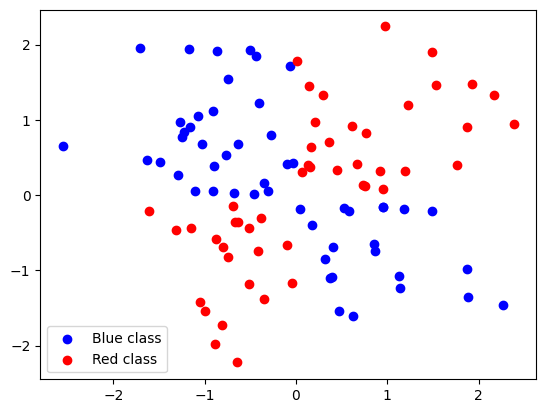

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dataset
np.random.seed(0)
n_samples = 100
X = np.random.randn(n_samples, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int) * 2 - 1  # labels: -1 for red, 1 for blue

# Plot dataset
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Blue class')
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color='red', label='Red class')
plt.legend()
plt.show()


In [31]:
# Convert dataset to your custom Value class
data = [ [Value(x[0]), Value(x[1])] for x in X]
targets = Y

# Initialize the MLP
mlp = MLP(2, [4, 4, 1])

# Training loop
for epoch in range(1000):
    # Forward pass
    predictions = [mlp(x) for x in data]
    loss = sum((pred - y) ** 2 for pred, y in zip(predictions, targets))
    
    # Zero gradients
    for p in mlp.parameters():
        p.grad = 0.0
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    for p in mlp.parameters():
        p.data -= 0.01 * p.grad
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.data:.4f}")

print("Training completed.")

Epoch 0, Loss: 100.9995
Epoch 100, Loss: 3.3808
Epoch 200, Loss: 0.2446
Epoch 300, Loss: 0.1266
Epoch 400, Loss: 0.0847
Epoch 500, Loss: 0.0628
Epoch 600, Loss: 0.0501
Epoch 700, Loss: 0.0414
Epoch 800, Loss: 0.0350
Epoch 900, Loss: 0.0299
Training completed.


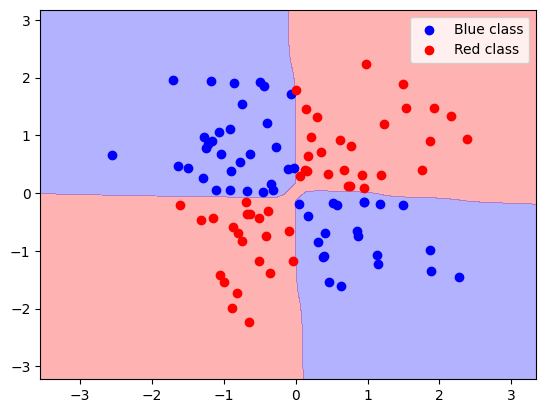

In [33]:
# Create a mesh grid for visualization
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
Z = np.array([mlp([Value(x), Value(y)]).data for x, y in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['red', 'blue'], alpha=0.3)
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Blue class')
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color='red', label='Red class')
plt.legend()
plt.show()


In [35]:
# Define new datapoints to test
new_points = [
    [2.0, 2.5],
    [-1.0, -1.5],
    [0.5, -0.5],
    [-2.5, 1.0]
]

# Convert new points to your custom Value class
new_data = [[Value(x[0]), Value(x[1])] for x in new_points]

# Use the trained MLP to predict the outputs for the new datapoints
new_predictions = [mlp(x) for x in new_data]

# Print the predictions
for point, pred in zip(new_points, new_predictions):
    print(f"Input: {point}, Output: {pred.data:.4f}")


Input: [2.0, 2.5], Output: -0.9954
Input: [-1.0, -1.5], Output: -0.9994
Input: [0.5, -0.5], Output: 0.9910
Input: [-2.5, 1.0], Output: 0.9990


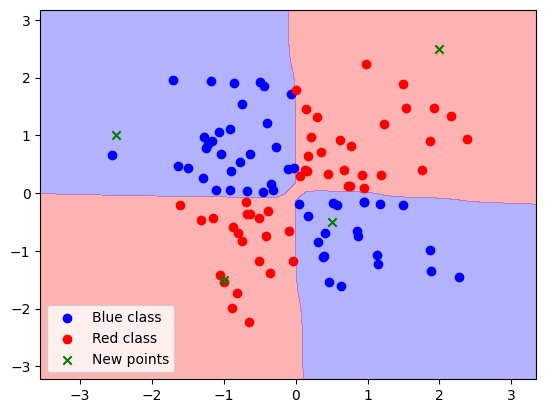

In [36]:
# Create a mesh grid for visualization
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
Z = np.array([mlp([Value(x), Value(y)]).data for x, y in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['red', 'blue'], alpha=0.3)
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Blue class')
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color='red', label='Red class')

# Plot new datapoints
new_points = np.array(new_points)legend
plt.scatter(new_points[:, 0], new_points[:, 1], color='green', label='New points', marker='x')

plt.legend()
plt.show()
